### Level 3 binned data: integerized sinusoidal tiling

Level 3 data is binned in 4 km x 4 km tiles arranged in 4320 latitude rows

Here is my verison of the perl program at  
https://oceancolor.gsfc.nasa.gov/docs/format/l3bins/ that calculates
the relationship between latitudes and logitudes and tiles on the NASA sinusoidal grid.  See
http://scipy-lectures.github.io/intro/language/oop.html for a quick intro into how classes work in python

In [1]:
from IPython.display import Image
EmbedNorth = Image('https://oceancolor.gsfc.nasa.gov/docs/format/l3bins/L3Bins.north.png',width=500)
EmbedSouth = Image('https://oceancolor.gsfc.nasa.gov/docs/format/l3bins/L3Bins.south.png',width=500)
WholeGrid = Image('https://oceancolor.gsfc.nasa.gov/docs/format/l3bins/L3Bins.png',width=600)

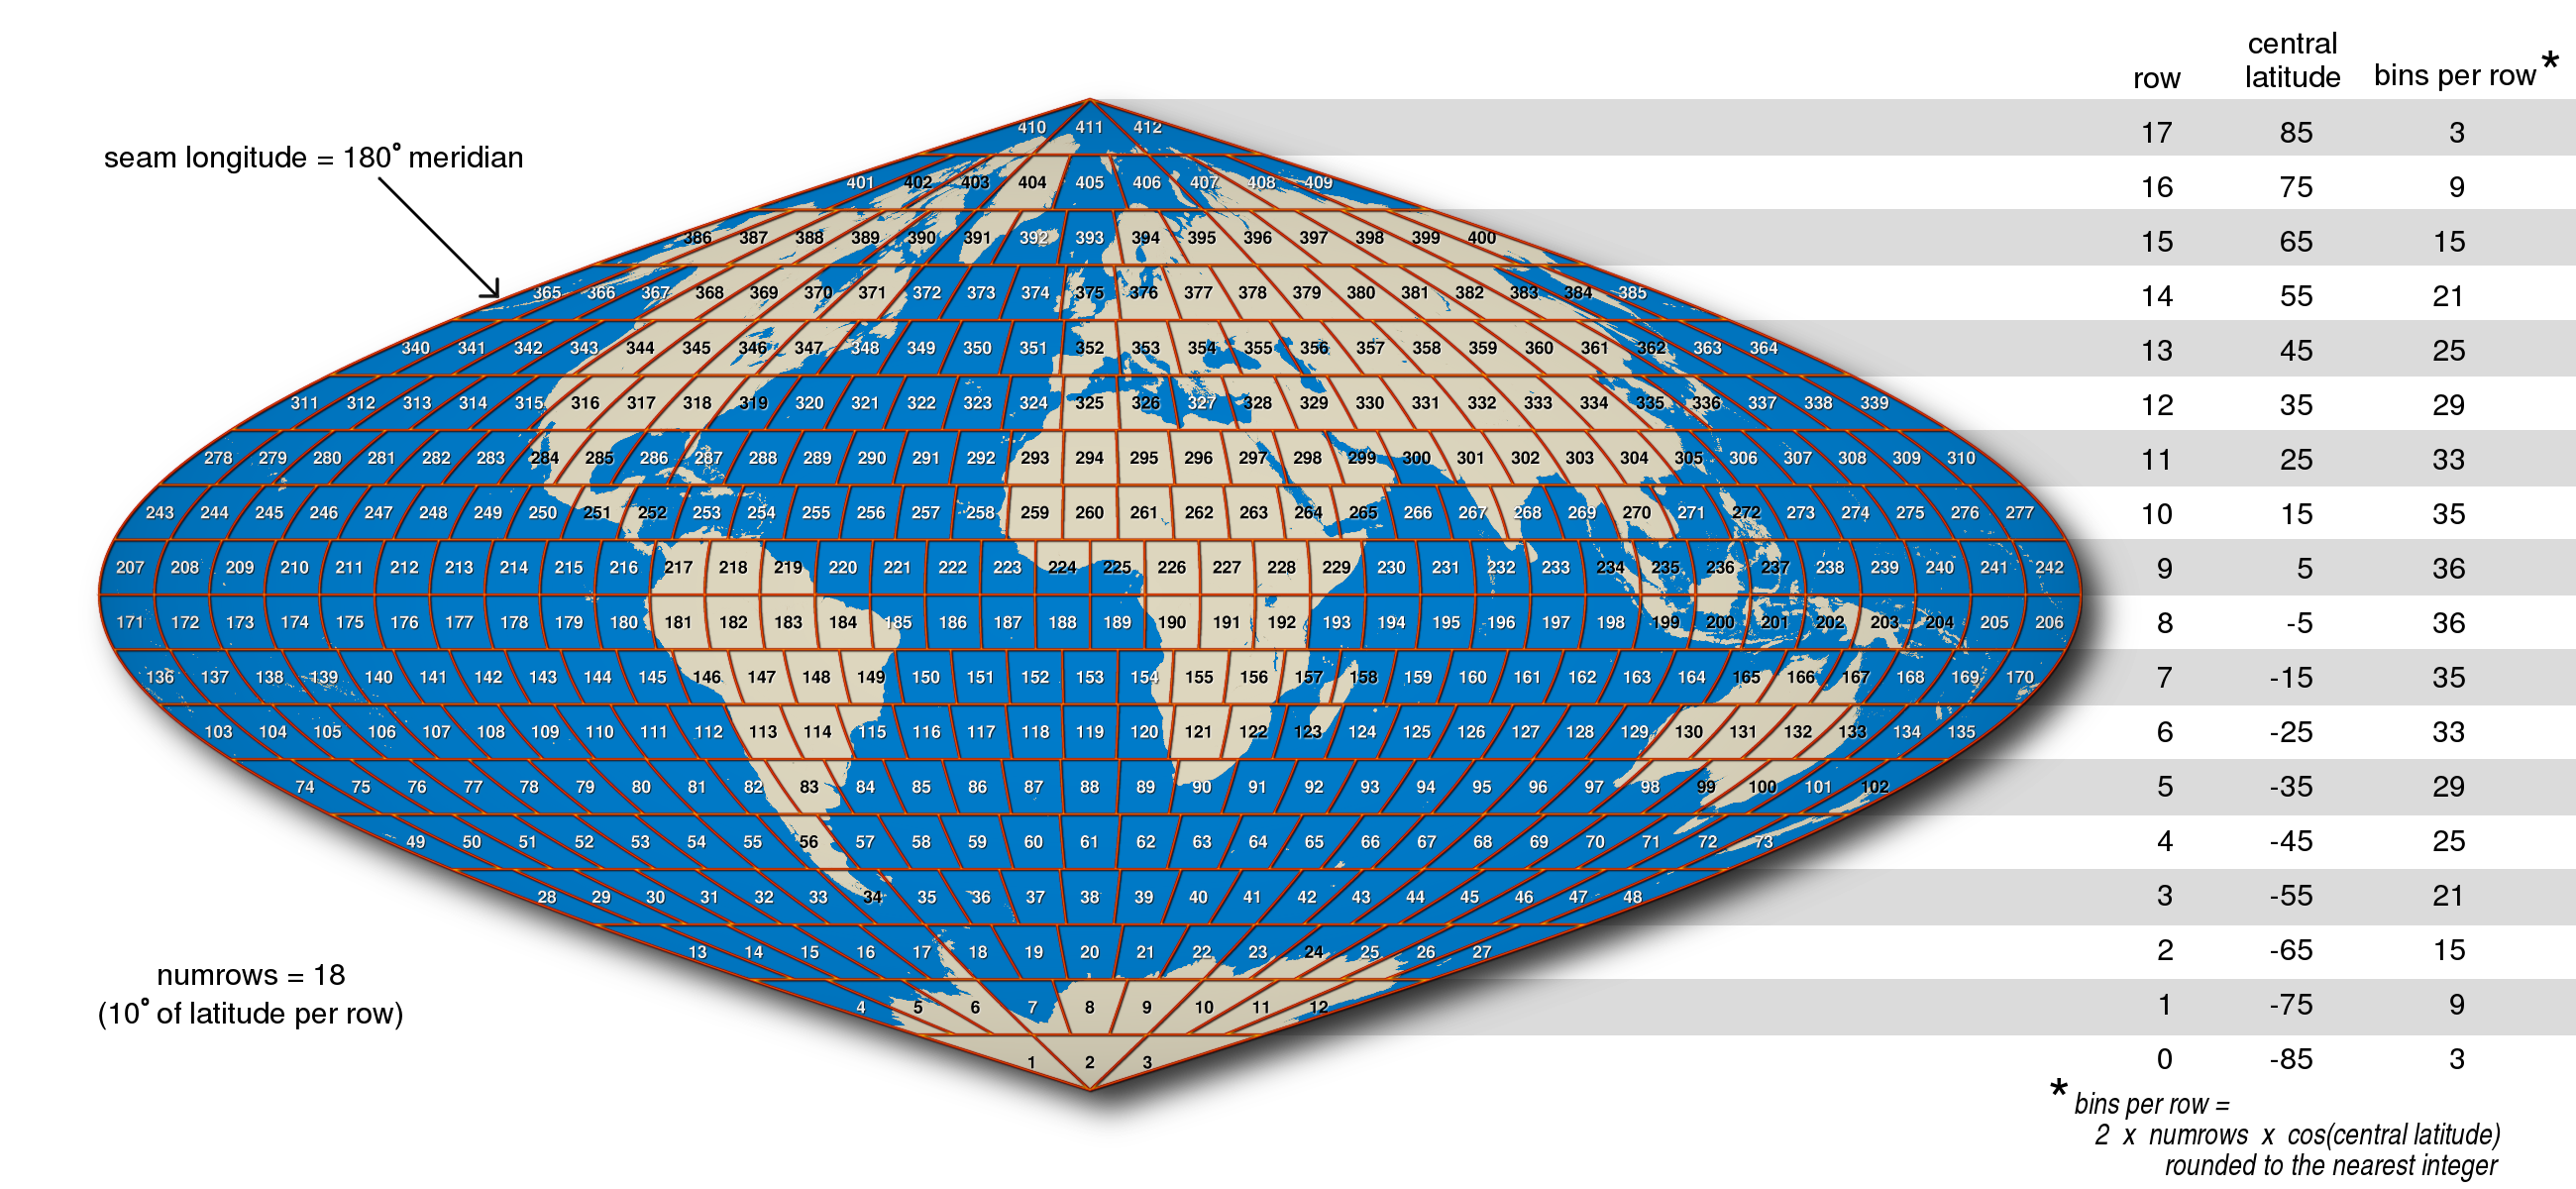

In [2]:
WholeGrid  #10 degree resolution with 18 rows

Note that UBC/Vancouver is located in bin 343

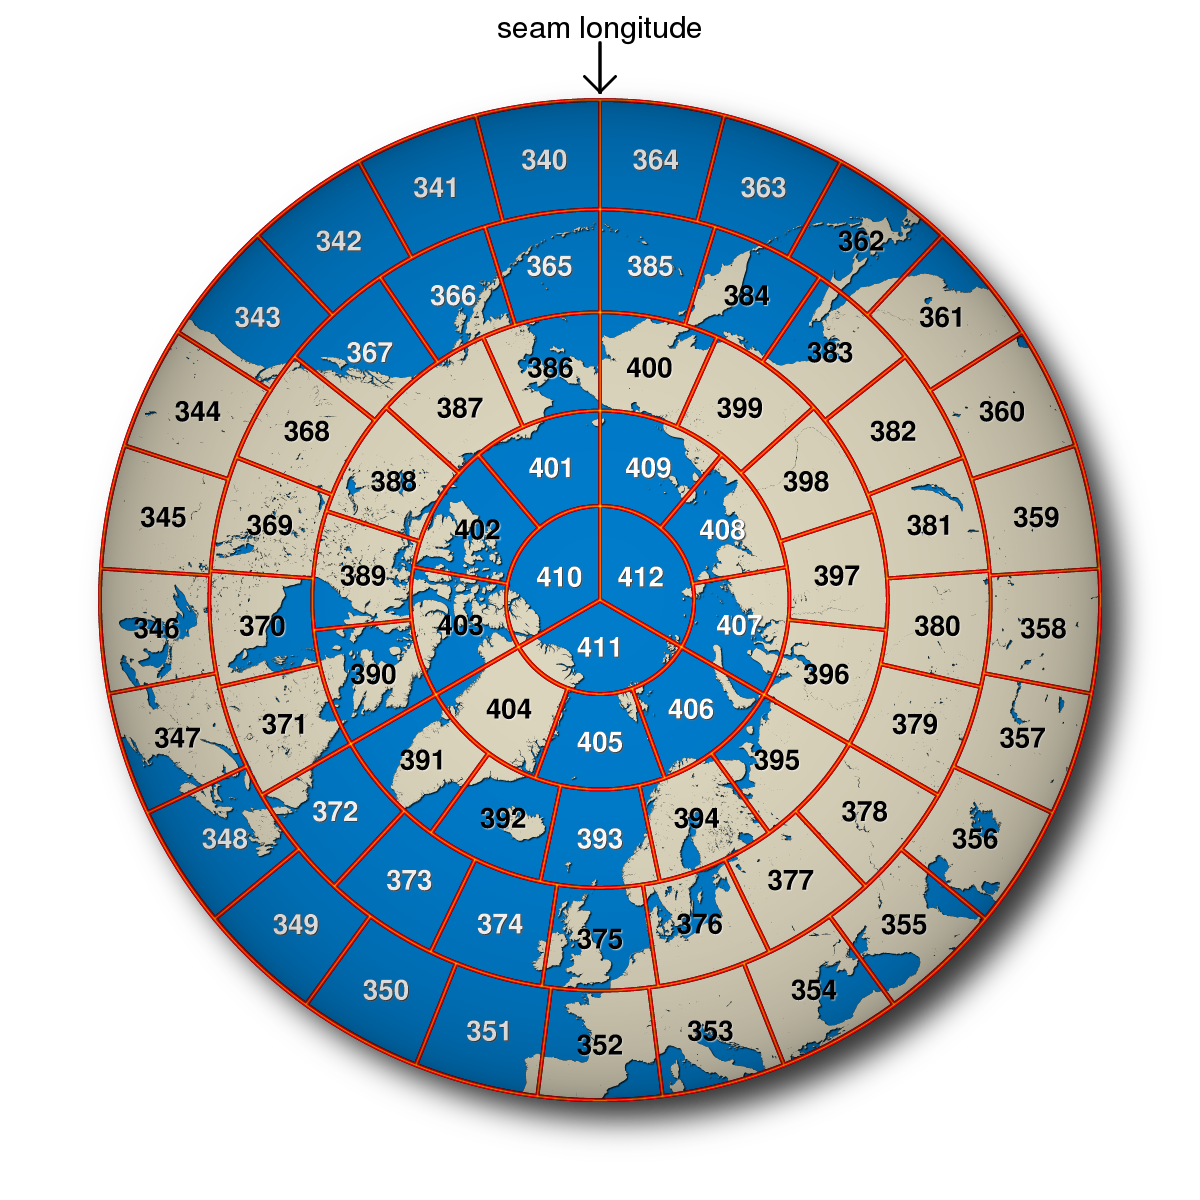

In [3]:
EmbedNorth

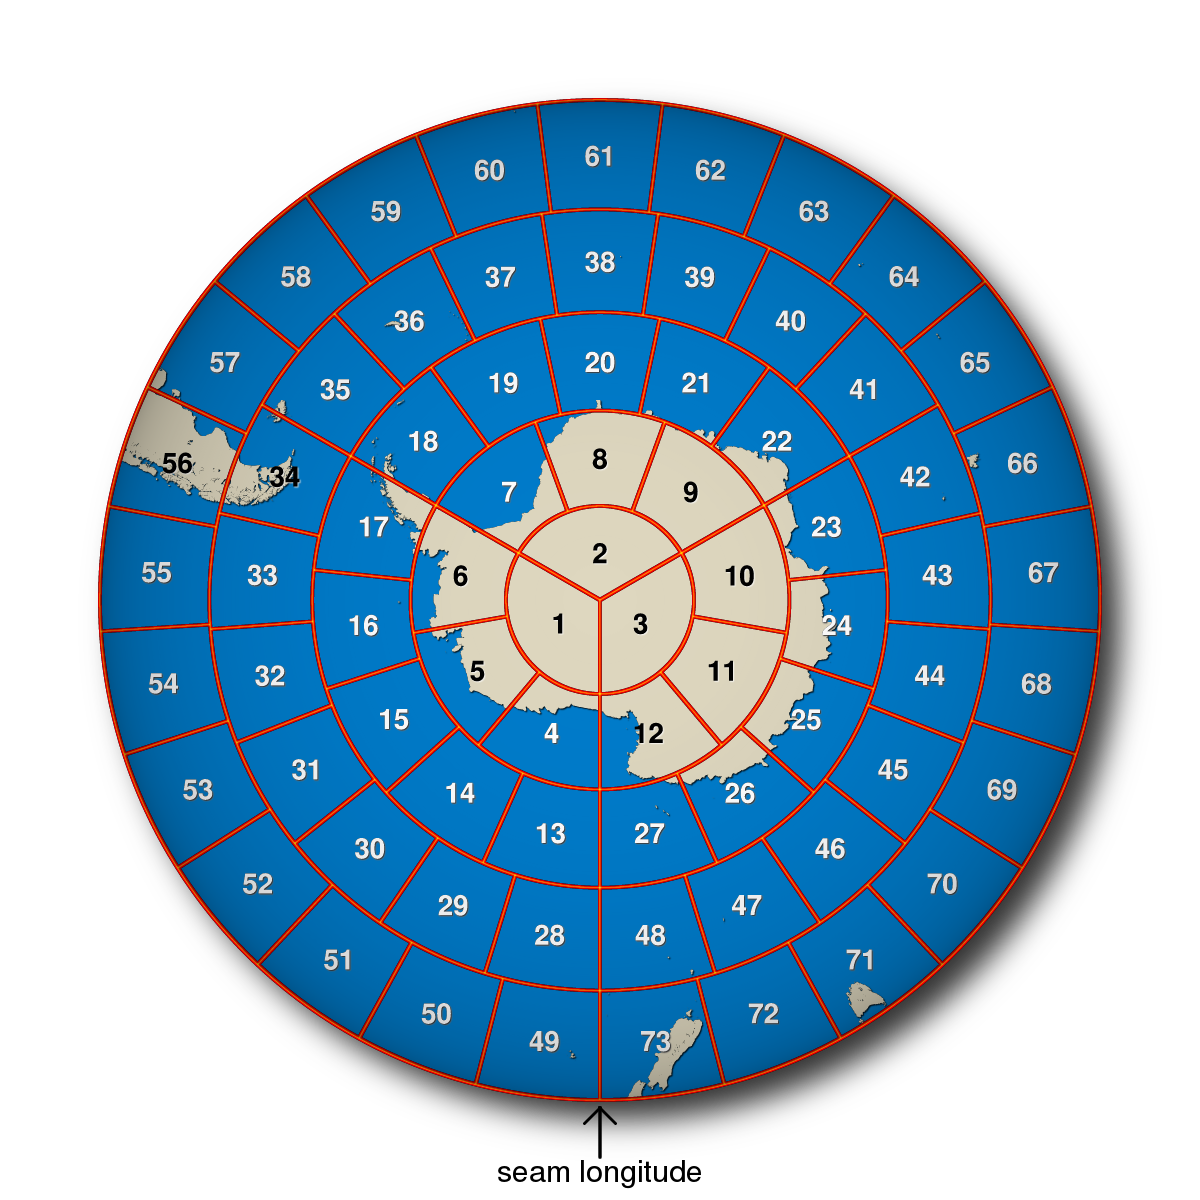

In [4]:
EmbedSouth

Here is my python translation  of the perl script called (bin_calc.py](https://github.com/phaustin/e582/blob/master/utilities/bin_calc.py)  that we'll use to map lon/lat to bin number

In [5]:
# %load /Users/phil/repos/e582_code/e582utils/bin_calc.py
"""
   python translation of the perl script at
   https://oceancolor.gsfc.nasa.gov/docs/format/l3bins/

   usage:
            import e582utils.bin_calc as tc
            test18=tc.Bin_calc(18)
            print(test18.lonlat2bin-123.25,49.2333))


            should output  bin=343

"""


# The following functions are based on the pseudocode found in Appendix A of:
# 
# Campbell, J.W., J.M. Blaisdell, and M. Darzi, 1995:
# Level-3 SeaWiFS Data Products: Spatial and Temporal Binning Algorithms.
# NASA Tech. Memo. 104566, Vol. 32,
# S.B. Hooker, E.R. Firestone, and J.G. Acker, Eds.,
# NASA Goddard Space Flight Center, Greenbelt, Maryland


import numpy as np 

class Bin_calc(object):

    def __init__(self,numrows):
        """
          initalize the class with the number of latitude rows in the tiling system.
          for Modis ocean color numrows=4320 for standard 4.64 km resolution

          initialize latbin (vector of length numrows containing center latitude of each row)
                     numbin (vector of length numrows containing number of bins in each row)
                     basebin (vector of length numrows containing bin number at the starting point of each row
        """
        self.numrows=numrows
        basebin=[1]
        numbin=[]
        latbin=[]
        for row in range(numrows):
            latbin.append(((row + 0.5)*180.0/self.numrows) - 90.0)
            numbin.append(int(2*self.numrows*np.cos(latbin[row]*np.pi/180.0) + 0.5))
            if row > 0:
                basebin.append(basebin[row-1] + numbin[row-1])
        self.basebin=np.array(basebin)
        self.numbin=np.array(numbin)
        self.latbin=np.array(latbin)
        self.totbins = basebin[numrows - 1] + numbin[numrows - 1] - 1

    def lat2row(self,lat):
        """
        given latitude in degrees return the rownumber
        """
        row=int((90. + lat)*self.numrows/180.)
        if row > self.numrows:
            row = self.numrows - 1
        return row

    def rowlon2bin(self,row,lon):
        """
        given the row number and the longitude in degrees,
        return the bin number
        """
        lon = self.constrain_lon(lon)
        col = int((lon + 180.0)*self.numbin[row]/360.0)
        if col >= self.numbin[row]:
            col = self.numbin[row] - 1
        return self.basebin[row] + col

    def lonlat2bin(self,lon,lat):
        """
        given the latitude and longitude in degrees
        return the bin number
        """
        lat = self.constrain_lat(lat)
        lon = self.constrain_lon(lon)
        row = self.lat2row(lat)
        col = int((lon + 180.0)*self.numbin[row]/360.0)
        if col >= self.numbin[row]:
            col = self.numbin[row] - 1

        return self.basebin[row] + col

    def bin2lonlat(self,bin):
        """
        give the bin number, return the latitude and logitude in degrees
        """
        row = self.numrows - 1
        if bin < 1:
            bin = 1
        while bin < self.basebin[row]:
            row-=1
        clat = self.latbin[row]
        clon = 360.0*(bin - self.basebin[row] + 0.5)/self.numbin[row] - 180.0
        return clon,clat

    def bin2bounds(self,bin):
        """
        given the bin number return the latitude of the north and south bin boundaries
        and the longitude of the east and west boundaries
        """
        row=self.numrows -1
        if bin < 1:
          bin=1
        while bin < self.basebin[row]:
            row-=1
        north = self.latbin[row] + (90.0/self.numrows)
        south = self.latbin[row] - (90.0/self.numrows)
        lon = 360.0*(bin - self.basebin[row] + 0.5)/self.numbin[row] - 180.0
        west = lon - 180.0/self.numbin[row]
        east = lon + 180.0/self.numbin[row]
        return north,south,west,east

    def constrain_lat(self,lat):
        """
        clip latitudes that are outside of -90 to 90
        """
        if lat > 90.:
            lat = 90
        if lat < -90.:
            lat = -90
        return lat

    def constrain_lon(self,lon):
        """
        clip longitudes that are outside of -180 to 180
        """
        if lon < -180:
          lon += 360
        if lon > 180:
          lon -= 360
        return lon

if __name__ == "__main__":
    
    test18=Bin_calc(18)
    print('lat lon bounds for bin 367: ',test18.bin2bounds(367))
    print('bounds for 411: ',test18.bin2bounds(411))
    print('bounds for 412: ',test18.bin2bounds(412))
    print('central lat lon for 367: ',test18.bin2lonlat(367))
    print('bin for UBC: ',test18.lonlat2bin(-123.25,49.2333))
          


lat lon bounds for bin 367:  (60.0, 50.0, -145.71428571428572, -128.57142857142856)
bounds for 411:  (90.0, 80.0, -60.0, 60.0)
bounds for 412:  (90.0, 80.0, 60.0, 180.0)
central lat lon for 367:  (-137.14285714285714, 55.0)
bin for UBC:  343


### test for an 18 row grid

From the map above, UBC should be in tile 343

In [6]:
test18=Bin_calc(18)
print('lat lon bounds for bin 367: ',test18.bin2bounds(367))
print('bounds for 411: ',test18.bin2bounds(411))
print('bounds for 412: ',test18.bin2bounds(412))
print('central lon lat for 367: ',test18.bin2lonlat(367))
print('bin for UBC: ',test18.lonlat2bin(-123.25,49.2333))


lat lon bounds for bin 367:  (60.0, 50.0, -145.71428571428572, -128.57142857142856)
bounds for 411:  (90.0, 80.0, -60.0, 60.0)
bounds for 412:  (90.0, 80.0, 60.0, 180.0)
central lon lat for 367:  (-137.14285714285714, 55.0)
bin for UBC:  343
